In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
import sklearn as sk
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [2]:
print(f"PyTorch Version:{torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"scikit-learn {sk.__version__}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch Version:2.1.0+cu121

Python 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Pandas 2.0.3
scikit-learn 1.3.1
GPU is available


In [3]:
transform = transforms.ToTensor() #definindo a conversão da imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para carregar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega a parte de validação
valloader= torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Type of dataiter: <class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


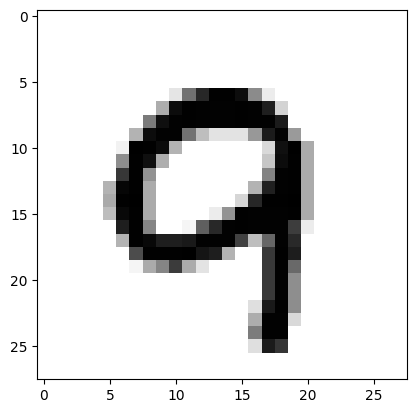

In [4]:
# Create an iterator for the training set
dataiter = iter(trainloader)
print("Type of dataiter:", type(dataiter))

# Get one batch of training data and labels
images, labels = next(dataiter)

# Display the first image from the batch
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

In [5]:
print(images[0].shape) #para verificar as dimensões do tensor de cada imagem.
print(labels[0].shape) #para verificar a dimensão da label

torch.Size([1, 28, 28])
torch.Size([])


In [6]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 128)  # Input layer, 784 neurons connected to 128
        self.linear2 = nn.Linear(128, 64)  # Hidden layer 1, 128 neurons connected to 64
        self.linear3 = nn.Linear(64, 10)  # Hidden layer 2, 64 neurons connected to 10

    def forward(self, x):
        x = F.relu(self.linear1(x))  # Activation function from input layer to hidden layer 1
        x = F.relu(self.linear2(x))  # Activation function from hidden layer 1 to hidden layer 2
        x = self.linear3(x)  # Activation function from hidden layer 2 to output layer; in this case f(x) = x
        return F.log_softmax(x, dim=1)


In [7]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=.01, momentum=.5)  # Define the policy for weight and bias updates
    inicio = time()  # Temporizador

    criterio = nn.NLLLoss()  # Definindo critério para calcular a perda
    EPOCHS = 10  #Numero de epochs que o algoritmo ira rodar
    modelo.train()  # Ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # Inicialiando a perda acumulada para a epoch atual

        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)  #convertendo as imagens para ciclos
            otimizador.zero_grad()  # Limpando os gradientes por causas dos ciclos anteriores

            output = modelo(images.to(device))  # Colocando os dados no modelo
            perda_instantanea = criterio(output, labels.to(device))  # Calculando a perda instantânea

            perda_instantanea.backward()  # Backpropagation baseado na perda
            otimizador.step()  # Atualizando os pesos e bias

            perda_acumulada += perda_instantanea.item()  # Atualizando a perda acumulada

        else:
            print("Epoch {} - Resulting Loss {}".format(epoch + 1, perda_acumulada / len(trainloader)))

    tempo_final = time()  # End time
    print('\nTraining time (in minutes)=', (tempo_final - inicio) / 60)
    
    return modelo

In [10]:
def plot_confusion_matrix(cm, y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_normalized = cm

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm_normalized[i, j]:.2f}' if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Calcular métricas
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # calculo de especificidade
    specificities = []
    for class_index in range(len(classes)):
        TN = cm.sum() - (cm[class_index, :].sum() + cm[:, class_index].sum() - cm[class_index, class_index])
        FP = cm[:, class_index].sum() - cm[class_index, class_index]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities.append(specificity)

    avg_specificity = np.mean(specificities)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Average Specificity: {avg_specificity:.2f}')
    print(f'Specificities per class: {specificities}')

In [11]:
def validacao(modelo, valloader, device, n_classes):
    conta_corretas, conta_todas = 0, 0
    y_true = []
    y_scores = []
    y_pred = []
    for images, labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            
            with torch.no_grad():
                logps = modelo(img.to(device))
                ps = torch.softmax(logps, dim=1)
                probab = ps.cpu().numpy()[0]
                label_pred = np.argmax(probab)
                label_true = labels.numpy()[i]
                
                y_scores.append(probab)
                y_true.append(label_true)
                y_pred.append(label_pred)
                
                if label_true == label_pred:
                    conta_corretas += 1
                  
            conta_todas += 1
    
    print('Total number of tested images=', conta_todas)
    print('Total number of correctly classified images=', conta_corretas)
    print('Model accuracy= {}%'.format(conta_corretas * 100 / conta_todas))
    
    cm = confusion_matrix(y_true, y_pred)    
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, y_true, y_pred, list(range(n_classes)))

    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    plot_roc_curve(y_true_bin, y_scores, n_classes)


In [12]:
def plot_roc_curve(y_true_bin, y_scores, n_classes):
    # Computar ROC para cada classe:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)
# Treinar o modelo
modelo_treinado = treino(modelo, trainloader, device)

Epoch 1 - Resulting Loss 1.1230274522736636
Epoch 2 - Resulting Loss 0.37313186409853416
Epoch 3 - Resulting Loss 0.3064490464895265
Epoch 4 - Resulting Loss 0.2668163977356862
Epoch 5 - Resulting Loss 0.2354729312942671
Epoch 6 - Resulting Loss 0.21019108559705937
Epoch 7 - Resulting Loss 0.18915901016165962
Epoch 8 - Resulting Loss 0.17126606314826304
Epoch 9 - Resulting Loss 0.15631003742580857
Epoch 10 - Resulting Loss 0.1429827491721031

Training time (in minutes)= 1.2387332836786906


Total number of tested images= 10000
Total number of correctly classified images= 9585
Model accuracy= 95.85%
Confusion Matrix:
[[ 965    0    1    2    0    4    5    2    1    0]
 [   0 1114    3    2    0    1    3    2   10    0]
 [   7    1  988    8    4    0    6    7   11    0]
 [   0    0    5  975    1   10    0    9    8    2]
 [   1    0    6    0  943    0    8    2    5   17]
 [   8    2    0   12    1  841   10    0   13    5]
 [   9    3    2    1    6   12  921    0    4    0]
 [   1    8   14    9    2    1    0  982    2    9]
 [   5    2    2   14    5    6    7    7  925    1]
 [   7    8    0   12   25    8    1   10    7  931]]


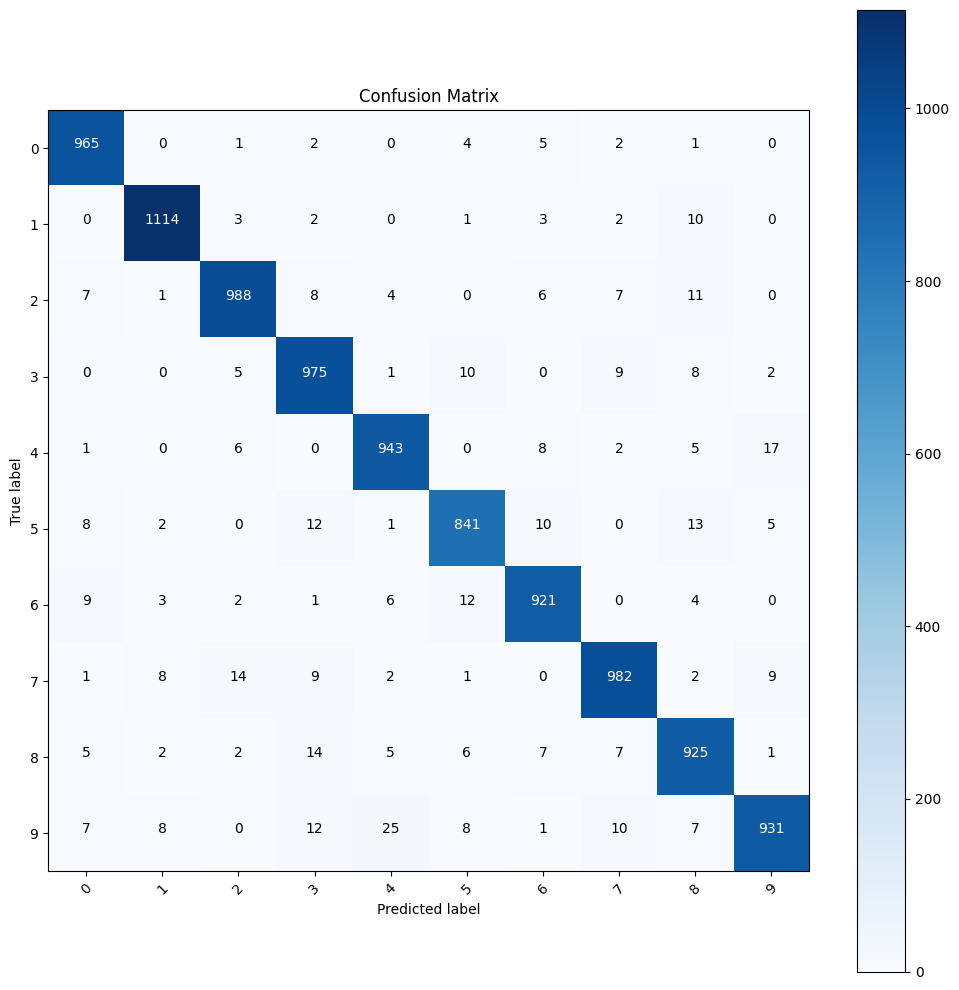

Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Average Specificity: 1.00
Specificities per class: [0.9957871396895787, 0.9972927241962775, 0.9963202497769849, 0.9933259176863182, 0.9951208693723663, 0.9953886693017128, 0.995576199955762, 0.9956531431119037, 0.9932417460669178, 0.9962184406628851]


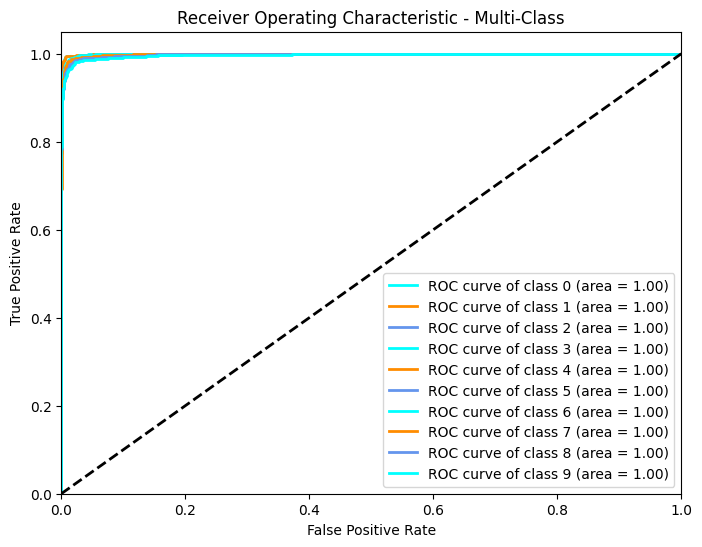

In [14]:
n_classes = 10
modelo_validado = validacao(modelo, valloader, device, n_classes)
